In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import time
import sklearn
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


In [2]:
start = time.time()
methy_breast = pd.read_csv('data_methylation_B.csv')
methy_breast_update = methy_breast.rename(columns={"Unnamed: 0": "attrib_name"})


train_clinical73_B = pd.read_csv('train_clinical_B73.csv')
#train_clinical73_B = train_clinical73_B.rename(columns={"Unnamed: 0.1": "attrib_name"})

test_clinical73_B = pd.read_csv('test_clinical_B73.csv')
#test_clinical73_B = test_clinical73_B.rename(columns={"Unnamed: 0.1": "attrib_name"})
print(train_clinical73_B.shape)
print(test_clinical73_B.shape)

train_clinical82_B = pd.read_csv('train_clinical_B82.csv')
#train_clinical82_B = train_clinical82_B.rename(columns={"Unnamed: 0.1": "attrib_name"})

test_clinical82_B = pd.read_csv('test_clinical_B82.csv')
#test_clinical82_B = test_clinical82_B.rename(columns={"Unnamed: 0.1": "attrib_name"})
print(train_clinical82_B.shape)
print(test_clinical82_B.shape)


end = time.time()

exec_time = end - start
print("data loading time: ", exec_time)

(431, 22)
(185, 22)
(492, 22)
(124, 22)
data loading time:  943.7239739894867


In [4]:
# receive the index so that we can match each techs
train_idx_82B = train_clinical82_B[['attrib_name']]
test_idx_82B = test_clinical82_B[['attrib_name']]

train_idx_73B = train_clinical73_B[['attrib_name']]
test_idx_73B = test_clinical73_B[['attrib_name']]

In [7]:
train_idx_82B

,attrib_name
0,TCGA.OK.A5Q2
1,TCGA.OL.A5D7
2,TCGA.BH.A8G0
3,TCGA.D8.A1JP
4,TCGA.E9.A24A
...,...
487,TCGA.AC.A2QI
488,TCGA.D8.A1XC
489,TCGA.E2.A1IJ
490,TCGA.E2.A14U


## Models and Support Functions

In [9]:
# Build up autoencoder model
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(embed_dim, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, 256)
        )
        self.decoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, embed_dim),
            nn.Tanh()
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        output = self.decoder(latent)
        return output

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(123)

#train_torch = torch.FloatTensor(train_scaled)
#test_torch = torch.FloatTensor(test_scaled)

criterion = nn.MSELoss()

k = 10
batch_size = 128
epochs = 10
lr = 0.001

kfold = KFold(n_splits=10, random_state=123, shuffle=True)


In [11]:
#define train function and validation function
def train_epoch(model, device, optimizer, loss_func, dataloader):
    model.train()
    train_loss = 0.0
    
    for features in dataloader:
        features = features.to(device)
        optimizer.zero_grad()
        output = model(features)
        loss = loss_func(output, features)
    
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss = train_loss/len(dataloader)

    return train_loss
  
def validation_epoch(model, device, loss_func, dataloader):
    model.eval()
    valid_loss = 0.0

    for features in dataloader:
        features = features.to(device)
        output = model(features)
        loss = loss_func(output, features)

        valid_loss += loss.item()
        
    valid_loss = valid_loss/len(dataloader)

    return valid_loss

## Load Breast 7:3 splits

In [5]:
train_breast_73B = methy_breast_update.merge(train_idx_73B, on='attrib_name', how="inner")
test_breast_73B = methy_breast_update.merge(test_idx_73B, on='attrib_name', how="inner")


print(methy_breast_update.shape)
print(train_breast_73B.shape)
print(test_breast_73B.shape)

(616, 335855)
(431, 335855)
(185, 335855)


In [6]:
# fill empty value with mean of each column

print(train_breast_73B.isna().sum())
train_breast_73B = train_breast_73B.fillna(train_breast_73B.mean())
print(train_breast_73B.isna().sum())
print("---------------------------------")
print(test_breast_73B.isna().sum())
test_breast_73B= test_breast_73B.fillna(test_breast_73B.mean())
print(test_breast_73B.isna().sum())


attrib_name               0
RBL2_cg00000029           0
VDAC3_cg00000236          0
ACTN1_cg00000289          0
ATP2A1_cg00000292         0
                         ..
SNORD66_ch.3.3596501R    19
FAM13B_ch.5.2533205R     20
PKD2L2_ch.5.2533205R     20
HNRNPK_ch.9.1116984R     31
MIR7-1_ch.9.1116984R     31
Length: 335855, dtype: int64
attrib_name              0
RBL2_cg00000029          0
VDAC3_cg00000236         0
ACTN1_cg00000289         0
ATP2A1_cg00000292        0
                        ..
SNORD66_ch.3.3596501R    0
FAM13B_ch.5.2533205R     0
PKD2L2_ch.5.2533205R     0
HNRNPK_ch.9.1116984R     0
MIR7-1_ch.9.1116984R     0
Length: 335855, dtype: int64
---------------------------------
attrib_name              0
RBL2_cg00000029          0
VDAC3_cg00000236         0
ACTN1_cg00000289         0
ATP2A1_cg00000292        0
                        ..
SNORD66_ch.3.3596501R    3
FAM13B_ch.5.2533205R     5
PKD2L2_ch.5.2533205R     5
HNRNPK_ch.9.1116984R     8
MIR7-1_ch.9.1116984R     8
Length

In [7]:
train_breast_73 = train_breast_73B.iloc[:, 1:]
test_breast_73 = test_breast_73B.iloc[:, 1:]
print(train_breast_73.shape)
print(test_breast_73.shape)
train_breast73_numpy = train_breast_73.to_numpy()
test_breast73_numpy = test_breast_73.to_numpy()

scaler_breast73 = MinMaxScaler()
train_breast73_scaled = scaler_breast73.fit_transform(train_breast73_numpy)
test_breast73_scaled = scaler_breast73.transform(test_breast73_numpy)

(431, 335854)
(185, 335854)


In [8]:
# convert to tensor type
train_breast73_torch = torch.FloatTensor(train_breast73_scaled)
test_breast73_torch = torch.FloatTensor(test_breast73_scaled)

In [ ]:
#save the attrib_name
train_breast73_name = train_breast_73B.iloc[:, 0]
test_breast73_name = test_breast_73B.iloc[:, 0]
print(train_breast73_name)
print(test_breast73_name)

train_breast73_name.to_csv("train_73B_idx.csv")
test_breast73_name.to_csv("test_73B_idx.csv")

### Breast 7:3 training and output

In [13]:
# 10 fold cross validation
train_fold_loss = []
valid_fold_loss = []
embed_dim = train_breast73_torch.shape[1]

# assign train_torch and test_torch
train_torch = train_breast73_torch
test_torch = test_breast73_torch

for k, (train_idx,valid_idx) in enumerate(kfold.split(np.arange(len(train_torch)))):
    
    print('Fold: ', k+1 )
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
      train_torch, batch_size=batch_size, sampler=train_sampler
  )
    valid_loader = torch.utils.data.DataLoader(
      train_torch, batch_size=batch_size, sampler=valid_sampler
  )

    model = autoencoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        train_loss = train_epoch(model, device, optimizer, criterion, train_loader)
        valid_loss = validation_epoch(model, device, criterion, valid_loader)

        print('epoch [{}/{}], train_loss:{:.4f}, valid_loss:{:.4f}'
          .format(epoch + 1, epochs, train_loss, valid_loss))
    
    train_fold_loss.append(train_loss)
    valid_fold_loss.append(valid_loss)

Fold:  1
epoch [1/10], train_loss:0.5057, valid_loss:0.2119
epoch [2/10], train_loss:0.1353, valid_loss:0.0563
epoch [3/10], train_loss:0.0543, valid_loss:0.0333
epoch [4/10], train_loss:0.0422, valid_loss:0.0346
epoch [5/10], train_loss:0.0338, valid_loss:0.0270
epoch [6/10], train_loss:0.0291, valid_loss:0.0249
epoch [7/10], train_loss:0.0294, valid_loss:0.0236
epoch [8/10], train_loss:0.0265, valid_loss:0.0226
epoch [9/10], train_loss:0.0277, valid_loss:0.0225
epoch [10/10], train_loss:0.0239, valid_loss:0.0224
Fold:  2
epoch [1/10], train_loss:0.5014, valid_loss:0.2166
epoch [2/10], train_loss:0.1358, valid_loss:0.0586
epoch [3/10], train_loss:0.0457, valid_loss:0.0411
epoch [4/10], train_loss:0.0366, valid_loss:0.0343
epoch [5/10], train_loss:0.0313, valid_loss:0.0314
epoch [6/10], train_loss:0.0278, valid_loss:0.0302
epoch [7/10], train_loss:0.0262, valid_loss:0.0295
epoch [8/10], train_loss:0.0265, valid_loss:0.0283
epoch [9/10], train_loss:0.0245, valid_loss:0.0280
epoch [10/10

In [ ]:
#draw diagram for 10 fold loss comparison

In [13]:
# formal training
embed_dim = train_breast73_torch.shape[1]


train_breast73_loader = torch.utils.data.DataLoader(
      train_breast73_torch, batch_size=batch_size, shuffle=True
  )
test_breast73_loader = torch.utils.data.DataLoader(
      test_breast73_torch, batch_size=batch_size, shuffle=False
  )

model_methy_73B = autoencoder().to(device)
optimizer = optim.Adam(model_methy_73B.parameters(), lr=lr)
                    
for epoch in range(epochs):
    train_loss = train_epoch(model_methy_73B, device, optimizer, criterion, train_breast73_loader)

    print('epoch [{}/{}], train_loss:{:.4f}'
        .format(epoch + 1, epochs, train_loss))

epoch [1/10], train_loss:0.5043
epoch [2/10], train_loss:0.1348
epoch [3/10], train_loss:0.0497
epoch [4/10], train_loss:0.0372
epoch [5/10], train_loss:0.0312
epoch [6/10], train_loss:0.0283
epoch [7/10], train_loss:0.0269
epoch [8/10], train_loss:0.0258
epoch [9/10], train_loss:0.0252
epoch [10/10], train_loss:0.0246


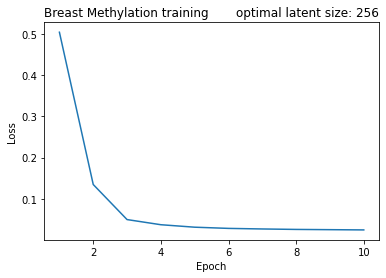

In [14]:
import matplotlib.pyplot as plt
plt.title("Breast Methylation training", loc="left")
plt.title("optimal latent size: 256", loc="right")
plt.xlabel("Epoch")
plt.ylabel("Loss")
loss = [0.5043, 0.1348, 0.0497, 0.0372, 0.0312, 0.0283, 0.0269, 0.0258, 0.0252, 0.0246]
plt.plot(range(1,11), loss)

In [15]:
# save and load the model
torch.save(model_methy_73B, "methy_73B.pt")

methy_73B = torch.load("methy_73B.pt")
methy_73B

C:\conda\lib\site-packages\torch\serialization.py:359: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=335854, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1024, out_features=335854, bias=True)
    (5): Tanh()
  )
)

In [16]:
# for train data only
methy_Tr73B_output = methy_73B.encoder(train_breast73_torch)
print(methy_Tr73B_output.shape)
print(methy_Tr73B_output)
methy_Tr73B_output = methy_Tr73B_output.cpu().detach().numpy()
np.savetxt('methy_Tr73B.csv', methy_Tr73B_output, delimiter=',')

torch.Size([431, 256])
tensor([[-3.8543,  2.9750,  1.4633,  ...,  1.6653,  1.6093,  1.2630],
        [-4.0798,  3.1637,  1.5636,  ...,  1.6746,  1.8015,  1.5152],
        [-4.3704,  3.3216,  1.7542,  ...,  1.7844,  1.9014,  1.6852],
        ...,
        [-3.5853,  2.8613,  1.2501,  ...,  1.5577,  1.5758,  1.2946],
        [-4.3588,  3.3441,  1.6394,  ...,  1.8042,  1.8744,  1.6326],
        [-3.3975,  2.8514,  1.1673,  ...,  1.6179,  1.4575,  1.2255]],
       grad_fn=<AddmmBackward>)


In [14]:
# for test data only
methy73B = torch.load('methy_73B.pt')
methy73B

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=335854, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1024, out_features=335854, bias=True)
    (5): Tanh()
  )
)

In [15]:
methy_Test73B_output = methy73B.encoder(test_breast73_torch)
print(methy_Test73B_output.shape)
print(methy_Test73B_output)
methy_Test73B_output = methy_Test73B_output.cpu().detach().numpy()
np.savetxt('methy_Test73B.csv', methy_Test73B_output, delimiter=',')

torch.Size([185, 256])
tensor([[-3.9318,  3.0726,  1.4551,  ...,  1.6895,  1.6813,  1.4507],
        [-3.8185,  3.0313,  1.3256,  ...,  1.7260,  1.6063,  1.5084],
        [-3.7031,  2.9749,  1.2746,  ...,  1.6596,  1.5919,  1.4191],
        ...,
        [-4.7298,  3.6131,  1.9112,  ...,  1.9490,  2.0221,  1.8171],
        [-4.1550,  3.2284,  1.4967,  ...,  1.8667,  1.7181,  1.5702],
        [-4.4544,  3.3996,  1.7519,  ...,  1.8849,  1.8532,  1.6689]],
       grad_fn=<AddmmBackward>)


In [ ]:
# for whole data only

## Load Breast 8:2 splits

In [16]:
train_breast_82B = methy_breast_update.merge(train_idx_82B, on='attrib_name', how="inner")
test_breast_82B = methy_breast_update.merge(test_idx_82B, on='attrib_name', how="inner")


print(methy_breast_update.shape)
print(train_breast_82B.shape)
print(test_breast_82B.shape)

(616, 335855)
(492, 335855)
(124, 335855)


In [ ]:
print(train_breast_82B.isna().sum())
train_breast_82B = train_breast_82B.fillna(train_breast_82B.mean())
print(train_breast_82B.isna().sum())
print("---------------------------------")
print(test_breast_82B.isna().sum())
test_breast_82B= test_breast_82B.fillna(test_breast_82B.mean())
print(test_breast_82B.isna().sum())


In [18]:
train_breast_82 = train_breast_82B.iloc[:, 1:]
test_breast_82 = test_breast_82B.iloc[:, 1:]
print(train_breast_82.shape)
print(test_breast_82.shape)
train_breast82_numpy = train_breast_82.to_numpy()
test_breast82_numpy = test_breast_82.to_numpy()

scaler_breast82 = MinMaxScaler()
train_breast82_scaled = scaler_breast82.fit_transform(train_breast82_numpy)
test_breast82_scaled = scaler_breast82.transform(test_breast82_numpy)

(492, 335854)
(124, 335854)


In [19]:
# convert to tensor type
train_breast82_torch = torch.FloatTensor(train_breast82_scaled)
test_breast82_torch = torch.FloatTensor(test_breast82_scaled)

In [21]:
#save the attrib_name
train_breast82_name = train_breast_82B.iloc[:, 0]
test_breast82_name = test_breast_82B.iloc[:, 0]
print(train_breast82_name)
print(test_breast82_name)

train_breast82_name.to_csv("train_82B_idx.csv")
test_breast82_name.to_csv("test_82B_idx.csv")

0      TCGA.3C.AAAU
1      TCGA.3C.AALI
2      TCGA.3C.AALJ
3      TCGA.3C.AALK
4      TCGA.4H.AAAK
           ...     
487    TCGA.WT.AB41
488    TCGA.XX.A899
489    TCGA.XX.A89A
490    TCGA.Z7.A8R5
491    TCGA.Z7.A8R6
Name: attrib_name, Length: 492, dtype: object
0      TCGA.5L.AAT0
1      TCGA.A1.A0SF
2      TCGA.A1.A0SI
3      TCGA.A1.A0SQ
4      TCGA.A2.A25E
           ...     
119    TCGA.PL.A8LX
120    TCGA.S3.AA12
121    TCGA.S3.AA17
122    TCGA.W8.A86G
123    TCGA.WT.AB44
Name: attrib_name, Length: 124, dtype: object


### Breast 8:2 training and output

In [22]:
# 10 fold cross validation
train_fold_loss = []
valid_fold_loss = []
embed_dim = train_breast82_torch.shape[1]

# assign train_torch and test_torch
train_torch = train_breast82_torch
test_torch = test_breast82_torch

for k, (train_idx,valid_idx) in enumerate(kfold.split(np.arange(len(train_torch)))):
    
    print('Fold: ', k+1 )
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
      train_torch, batch_size=batch_size, sampler=train_sampler
  )
    valid_loader = torch.utils.data.DataLoader(
      train_torch, batch_size=batch_size, sampler=valid_sampler
  )

    model = autoencoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        train_loss = train_epoch(model, device, optimizer, criterion, train_loader)
        valid_loss = validation_epoch(model, device, criterion, valid_loader)

        print('epoch [{}/{}], train_loss:{:.4f}, valid_loss:{:.4f}'
          .format(epoch + 1, epochs, train_loss, valid_loss))
    
    train_fold_loss.append(train_loss)
    valid_fold_loss.append(valid_loss)

Fold:  1
epoch [1/10], train_loss:0.4999, valid_loss:0.1857
epoch [2/10], train_loss:0.1230, valid_loss:0.0691
epoch [3/10], train_loss:0.0502, valid_loss:0.0364
epoch [4/10], train_loss:0.0337, valid_loss:0.0306
epoch [5/10], train_loss:0.0293, valid_loss:0.0273
epoch [6/10], train_loss:0.0268, valid_loss:0.0263
epoch [7/10], train_loss:0.0259, valid_loss:0.0261
epoch [8/10], train_loss:0.0257, valid_loss:0.0252
epoch [9/10], train_loss:0.0249, valid_loss:0.0255
epoch [10/10], train_loss:0.0248, valid_loss:0.0248
Fold:  2
epoch [1/10], train_loss:0.5201, valid_loss:0.2510
epoch [2/10], train_loss:0.1490, valid_loss:0.0622
epoch [3/10], train_loss:0.0518, valid_loss:0.0342
epoch [4/10], train_loss:0.0339, valid_loss:0.0282
epoch [5/10], train_loss:0.0297, valid_loss:0.0251
epoch [6/10], train_loss:0.0276, valid_loss:0.0239
epoch [7/10], train_loss:0.0263, valid_loss:0.0228
epoch [8/10], train_loss:0.0253, valid_loss:0.0222
epoch [9/10], train_loss:0.0251, valid_loss:0.0219
epoch [10/10

In [23]:
# formal training
train_breast82_loader = torch.utils.data.DataLoader(
      train_breast82_torch, batch_size=batch_size, shuffle=True
  )
test_breast82_loader = torch.utils.data.DataLoader(
      test_breast82_torch, batch_size=batch_size, shuffle=False
  )

model_methy_82B = autoencoder().to(device)
optimizer = optim.Adam(model_methy_82B.parameters(), lr=lr)

for epoch in range(epochs):
    train_loss = train_epoch(model_methy_82B, device, optimizer, criterion, train_breast82_loader)

    print('epoch [{}/{}], train_loss:{:.4f}'
        .format(epoch + 1, epochs, train_loss))

epoch [1/10], train_loss:0.5158
epoch [2/10], train_loss:0.1368
epoch [3/10], train_loss:0.0505
epoch [4/10], train_loss:0.0350
epoch [5/10], train_loss:0.0300
epoch [6/10], train_loss:0.0273
epoch [7/10], train_loss:0.0258
epoch [8/10], train_loss:0.0250
epoch [9/10], train_loss:0.0246
epoch [10/10], train_loss:0.0244


In [24]:
# save and load the model
torch.save(model_methy_82B, "methy_82B.pt")

methy_82B = torch.load("methy_82B.pt")
methy_82B

C:\conda\lib\site-packages\torch\serialization.py:359: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=335854, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1024, out_features=335854, bias=True)
    (5): Tanh()
  )
)

In [25]:
# for train data only
methy_Tr82B_output = methy_82B.encoder(train_breast82_torch)
print(methy_Tr82B_output.shape)
print(methy_Tr82B_output)
methy_Tr82B_output = methy_Tr82B_output.cpu().detach().numpy()
np.savetxt('methy_Tr82B.csv', methy_Tr82B_output, delimiter=',')

torch.Size([492, 256])
tensor([[ 3.5710,  1.4257,  2.1970,  ..., -2.5272, -1.8212,  2.5967],
        [ 3.7296,  1.5388,  2.3681,  ..., -2.7706, -1.9150,  2.7146],
        [ 3.9683,  1.7149,  2.6789,  ..., -3.1441, -2.0104,  2.8725],
        ...,
        [ 3.2604,  1.2846,  1.9492,  ..., -2.2460, -1.7404,  2.4628],
        [ 3.9428,  1.6234,  2.6157,  ..., -3.0173, -2.0498,  2.9230],
        [ 3.1766,  1.2524,  1.7818,  ..., -2.1168, -1.6669,  2.4237]],
       grad_fn=<AddmmBackward>)


In [20]:
#for test data only
methy82B = torch.load('methy_82B.pt')
methy82B

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=335854, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1024, out_features=335854, bias=True)
    (5): Tanh()
  )
)

In [21]:
methy_Test82B_output = methy82B.encoder(test_breast82_torch)
print(methy_Test82B_output.shape)
print(methy_Test82B_output)
methy_Test82B_output = methy_Test82B_output.cpu().detach().numpy()
np.savetxt('methy_Test82B.csv', methy_Test82B_output, delimiter=',')

torch.Size([124, 256])
tensor([[ 3.5870,  1.4484,  2.2740,  ..., -2.6455, -1.8562,  2.6672],
        [ 3.4173,  1.4137,  2.0979,  ..., -2.4712, -1.8428,  2.6139],
        [ 3.3464,  1.3543,  2.0041,  ..., -2.3498, -1.8122,  2.5525],
        ...,
        [ 3.8168,  1.6809,  2.5224,  ..., -3.0009, -2.0387,  2.8993],
        [ 3.7411,  1.5333,  2.3327,  ..., -2.7540, -1.9547,  2.8322],
        [ 4.0412,  1.7152,  2.6860,  ..., -3.1677, -2.0665,  2.9739]],
       grad_fn=<AddmmBackward>)
